# Prepare sample point neighborhood stats within each study region
### *use odense as an example in this notebook
Description: This script is for preparing all sample points indicators/stats.  
All the cities should run this script first to get the pre-prepared sample points before running the aggregation scripts (aggr.py)

**City-specific input data**  

| Input data | Geometry | Description |
| --- | --- | --- |
| aos_nodes_30m_line | point | Public open space pseudo entry points (points on boundary of park every 20m within 30m of road) |
| clean_intersections_12m |	point |	Clean intersections (not required; counts are associated with pop_ghs_2015) |
| dest_type	| NA (non-spatial) |	Summary of destinations and counts |
| destinations |	point	| OSM destinations retrieved using specified definitions (only require: supermarkets, convenience,  pt_any --- use dest_name_full to determine, will need to combine convenience destinations) |
| pop_ghs_2015	| polygon	| 250m hex grid, associated with area_sqkm (fixed), population estimate (2015), population per sq km, intersection count, intersections per sq km |
| urban_sample_points |	point |	Sample points in urban region (every 30m along pedestrian network) |
| urban_study_region | polygon | Urban study region (intersection of city boundary and GHS 2015 urban centre layer) |


**Two outputs:**
1. average poplulation and intersection density per sample point
2. accessibility, daily living and walkability score per sample point

notice: must close the geopackage connection in QGIS.Otherwise, an error occurred when reading

In [28]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
import os
import setup_sp as ssp # functions for setting up sample point stats used in this notebook
import time
from multiprocessing import Pool, cpu_count, Value, Manager, Process
from functools import partial
import json
import sys
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:
# get the work directory
dirname = os.path.abspath('')

# the configuration file should put in the "/configuration" folder located at the same folder as scripts
jsonFile = "configuration/" + sys.argv[1]
jsonPath = os.path.join(dirname, jsonFile)

# load city-specific configeration file (e.g. Odense)
with open("configuration/odense.json") as json_file:
    config = json.load(json_file)

In [13]:
# read or create projected graphml
graphmlProj_path = os.path.join(dirname, config["folder"],
                                    config["graphmlProj_name"])
G_proj = ssp.readGraphml(graphmlProj_path, config)

Read network from disk.


In [14]:
#  geopackage path where to read all the required layers and save processing layers to it
gpkgPath = os.path.join(dirname, config["folder"],config["geopackagePath"])

# read hexes in memory, hex layer in city-specific geopackage contain population and intersection info.
hex250 = gpd.read_file(gpkgPath, layer=config["parameters"]["hex250"])

# get nodes from the city projected graphml
gdf_nodes = ox.graph_to_gdfs(G_proj, nodes=True, edges=False)
gdf_nodes.osmid = gdf_nodes.osmid.astype(int)
gdf_nodes = gdf_nodes.drop_duplicates(subset='osmid')
# keep only the unique node id column
gdf_nodes_simple = gdf_nodes[['osmid']].copy()
del gdf_nodes

## 1. Calculate average poplulation and intersection density for each sample point in study regions
**The steps are as follows:**
1. use the OSM pedestrain network (graphml in disk) to generate local 1600m neighborhood per urban sample points (sample point in disk)
2. load 250m hex grid from disk with population and network intersections density data
3. then calculate population and intersection density within each local walkable neighborhood (1600m) by averaging the hex level pop and intersection density data; final result is urban sample point dataframe with osmid, pop density, and intersection density.

In [5]:
startTime = time.time()
print('Calculate average poplulation and intersection density.')
if os.path.isfile(os.path.join(dirname, config["folder"],
                     config['parameters']['tempCSV'])):
    gdf_nodes_simple = pd.read_csv(os.path.join(dirname, config["folder"],
                     config['parameters']['tempCSV']))

# set osmid as index
gdf_nodes_simple.set_index('osmid', inplace=True, drop=False)
print('The time to finish average pop and intersection density is: {}'.
      format(time.time() - startTime))



Calculate average poplulation and intersection density.
The time to finish average pop and intersection density is: 0.035325050354003906


In [15]:
startTime = time.time()
# read from disk if exist
if os.path.isfile(os.path.join(dirname, config["folder"],
                     config['parameters']['tempCSV'])):
    print('Read poplulation and intersection density from local file.')
    gdf_nodes_simple = pd.read_csv(os.path.join(dirname, config["folder"],
                     config['parameters']['tempCSV']))

# otherwise,calculate using single thred or multiprocessing
else:
    print('Calculate average poplulation and intersection density.')
    
    # read search distance from json file, the default should be 1600m
    # the search distance is used to defined the radius of a sample point as a local neighborhood
    distance = config['parameters']['search_distance']

    # read pop density and intersection density filed names from the  city-specific configeration file
    pop_density = config['samplePoint_fieldNames'][
        'sp_local_nh_avg_pop_density']
    intersection_density = config['samplePoint_fieldNames'][
        'sp_local_nh_avg_intersection_density']

    # get the nodes GeoDataFrame row length for use in later iteration
    rows = gdf_nodes_simple.shape[0]

    # using single thread approach
    # create counter for loop
    val = Value('i', 0)
    df_result = gdf_nodes_simple['osmid'].apply(
        ssp.calc_sp_pop_intect_density,
        args=(G_proj, hex250, pop_density, intersection_density, distance,
              val, rows))
    # Concatenate the average of population and intersections back to the df of sample points
    gdf_nodes_simple = pd.concat([gdf_nodes_simple, df_result], axis=1)

    # save the pop and intersection density to a CSV file
    gdf_nodes_simple.to_csv(
            os.path.join(dirname, config["folder"],
                         config['parameters']['tempCSV']))

# set osmid as index
gdf_nodes_simple.set_index('osmid', inplace=True, drop=False)
print('The time to finish average pop and intersection density is: {}'.
          format(time.time() - startTime))

# read sample points from disk (in city-specific geopackage)
samplePointsData = gpd.read_file(
    gpkgPath, layer=config["parameters"]["samplePoints"])

# create 'hex_id' for sample point, if it not exists
if "hex_id" not in samplePointsData.columns.tolist():
    samplePointsData = ssp.createHexid(samplePointsData, hex250)

Read poplulation and intersection density from local file.
The time to finish average pop and intersection density is: 0.04163193702697754
Start to create hex_id for sample points


In [18]:
# show sample point pop and intersection density data
gdf_nodes_simple.head()

,Unnamed: 0,osmid,sp_local_nh_avg_pop_density,sp_local_nh_avg_intersection_density
osmid,,,,
2740715523,2740715523,2740715523,3392.689414,147.561738
2740715526,2740715526,2740715526,3305.036650,145.387227
2740715529,2740715529,2740715529,3285.157335,150.178329
2740715531,2740715531,2740715531,3303.762301,150.311423
1732902925,1732902925,1732902925,1354.224757,98.928767


## Calculate accessibility to POI (supermarket,convenience,pt,pso), daily living and walkability for sample points
**steps as follow:**
   1. using pandana packadge to calculate distance to access from sample points to destinations (daily living destinations, public open space)
   2. calculate accessibiity score per sample point: transform accessibility distance to binary measure: 1 if access <= 500m, 0 otherwise
   3. calculate daily living score by summing the accessibiity scores to all POIs (excluding pos)
   4. calculate walkability score per sample point: get zscores for daily living accessibility, populaiton density and intersections pop_density; sum these three zscores at sample point level


In [19]:
print('Calculate assessbility to POIs.')

# create the pandana network, use network nodes and edges
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_proj)
net = ssp.create_pdna_net(gdf_nodes, gdf_edges)

# read "daily living destinations" point layer (supermarket,convenience,pt) from disk
gdf_poi1 = gpd.read_file(gpkgPath,
                         layer=config["parameters"]["destinations"])

# read field names from json file
poi_names = [
    config["parameters"]["supermarket"],
    config["parameters"]["convenience"], config["parameters"]["PT"]
]

# read accessibility distance from configuration file, which is 500m
distance = config["parameters"]["accessibility_distance"]

# read output field names from json file
output_fieldNames1 = [
    config["samplePoint_fieldNames"]["sp_nearest_node_supermarket_dist"],
    config["samplePoint_fieldNames"]["sp_nearest_node_convenience_dist"],
    config["samplePoint_fieldNames"]["sp_nearest_node_pt_dist"]
]

# zip the input and output field names
names1 = list(zip(poi_names, output_fieldNames1))

# calculate the distance from each node to POI
gdf_poi_dist1 = ssp.cal_dist_node_to_nearest_pois(gdf_poi1, distance, net, *(names1))

# read open space "aos_nodes_30m_line" layer from geopackage
gdf_poi2 = gpd.read_file(gpkgPath, layer=config["parameters"]["pos"])

# read field names from json file
names2 = [(config["parameters"]["pos"],
           config["samplePoint_fieldNames"]["sp_nearest_node_pos_dist"])]

# calculate the distance from each node to public open space,
# filterattr=False to indicate the layer is "aos_nodes_30m_line"
gdf_poi_dist2 = ssp.cal_dist_node_to_nearest_pois(gdf_poi2,
                                 distance,
                                 net,
                                 *names2,
                                 filterattr=False)

# concatenate two dataframes into one
gdf_nodes_poi_dist = pd.concat([gdf_nodes, gdf_poi_dist1, gdf_poi_dist2],
                               axis=1)

# convert distance of each nodes to binary index
output_fieldNames1.append(
    config["samplePoint_fieldNames"]["sp_nearest_node_pos_dist"])
output_fieldNames2 = [
    config["samplePoint_fieldNames"]["sp_nearest_node_supermarket_binary"],
    config["samplePoint_fieldNames"]["sp_nearest_node_convenience_binary"],
    config["samplePoint_fieldNames"]["sp_nearest_node_pt_binary"],
    config["samplePoint_fieldNames"]["sp_nearest_node_pos_binary"]
]
names3 = list(zip(output_fieldNames1, output_fieldNames2))
gdf_nodes_poi_dist = ssp.convert_dist_to_binary(gdf_nodes_poi_dist, *names3)

# set index of gdf_nodes_poi_dist, using 'osmid' as the index
gdf_nodes_poi_dist.set_index('osmid', inplace=True, drop=False)

# drop unuseful columns
gdf_nodes_poi_dist.drop(
    ['geometry', 'id', 'lat', 'lon', 'y', 'x', 'highway', 'ref'],
    axis=1,
    inplace=True)

# for each sample point, create a new field to save the osmid of the closest nodes,
# which is used for joining to nodes
samplePointsData['closest_node_id'] = np.where(
    samplePointsData.n1_distance <= samplePointsData.n2_distance,
    samplePointsData.n1, samplePointsData.n2)

# join the two tables (sample point pop and intersection density + node to POIs accessibility distance)
# based on node id (link sample points to nearest nodes)
samplePointsData['closest_node_id'] = samplePointsData[
    'closest_node_id'].astype(int)

# first, join accessibility to POIs results from nodes to sample points based on node id
samplePointsData = samplePointsData.join(gdf_nodes_poi_dist,
                                         on='closest_node_id',
                                         how='left',
                                         rsuffix='_nodes1')

# second, join pop and intersection density from nodes to sample points based on node id
samplePointsData = samplePointsData.join(gdf_nodes_simple,
                                         on='closest_node_id',
                                         how='left',
                                         rsuffix='_nodes2')

# drop the nan rows samplePointsData, and deep copy to a new variable
samplePointsData_withoutNan = samplePointsData.dropna().copy()
nanData = samplePointsData[~samplePointsData.index.
                           isin(samplePointsData_withoutNan.index)]

# save the nan rows to a new layer in geopackage, in case someone will check it
nanData.to_file(gpkgPath,
                layer=config["parameters"]["dropNan"],
                driver='GPKG')
del nanData


Calculate assessbility to POIs.


In [20]:
# create new field for daily living score,sum accessibility to POIs to get the daily living scores 
#(e.g. supermarket, public transport, and convenience store, exclude public open space)
output_fieldNames2.pop()
samplePointsData_withoutNan[
    'sp_daily_living_score'] = samplePointsData_withoutNan[
        output_fieldNames2].sum(axis=1)

oriFieldNames = [
    config["samplePoint_fieldNames"]["sp_local_nh_avg_pop_density"],
    config["samplePoint_fieldNames"]
    ["sp_local_nh_avg_intersection_density"],
    config["samplePoint_fieldNames"]["sp_daily_living_score"]
]
newFieldNames = [
    config["samplePoint_fieldNames"]["sp_zscore_local_nh_avgpopdensity"],
    config["samplePoint_fieldNames"]["sp_zscore_local_nh_avgintdensity"],
    config["samplePoint_fieldNames"]["sp_zscore_daily_living_score"]
]

# zip the old and new field names together as input, and calculate zscore
samplePointsData_withoutNan = ssp.cal_zscores(samplePointsData_withoutNan,
                                              oriFieldNames, newFieldNames)

# sum these three zscores for walkability index
samplePointsData_withoutNan[
    'sp_walkability_index'] = samplePointsData_withoutNan[
        newFieldNames].sum(axis=1)

# save the sample points with all the desired results to a new layer in geopackage
samplePointsData_withoutNan.to_file(
    gpkgPath,
    layer=config["parameters"]["samplepointResult"],
    driver='GPKG')


In [21]:
len(samplePointsData_withoutNan)

50717

In [22]:
samplePointsData_withoutNan.columns

Index(['point_id', 'edge_ogc_fid', 'metres', 'n1', 'n2', 'n1_distance',
       'n2_distance', 'geometry', 'hex_id', 'closest_node_id', 'osmid',
       'sp_nearest_node_supermarket_dist', 'sp_nearest_node_convenience_dist',
       'sp_nearest_node_pt_dist', 'sp_nearest_node_pos_dist',
       'sp_nearest_node_supermarket_binary',
       'sp_nearest_node_convenience_binary', 'sp_nearest_node_pt_binary',
       'sp_nearest_node_pos_binary', 'Unnamed: 0', 'osmid_nodes2',
       'sp_local_nh_avg_pop_density', 'sp_local_nh_avg_intersection_density',
       'sp_daily_living_score', 'sp_zscore_local_nh_avgpopdensity',
       'sp_zscore_local_nh_avgintdensity', 'sp_zscore_daily_living_score',
       'sp_walkability_index'],
      dtype='object')

Text(0.5, 0.95, 'Local Sample Point walkability')

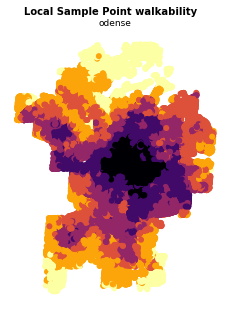

In [32]:
col=['sp_walkability_index']

fig, ax = plt.subplots(figsize=(5, 5))

#plot indicators
ax = samplePointsData_withoutNan.plot(ax=ax, column=col, scheme='NaturalBreaks', k=6, cmap='inferno_r', edgecolor='none')

ax.set_title(config['study_region'], fontsize=9)
ax.set_axis_off()

# add a title to the figure
fig.suptitle('Local Sample Point walkability', y=0.95, fontsize=10, weight='bold')